##Підключення до бази даних


In [ ]:
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import pearsonr
auth.authenticate_user()

project_id = 'data-analytics-mate'
client = bigquery.Client(project=project_id)


## Створення датасету

In [ ]:
sql = """
SELECT
    s.date AS order_date,
    s.ga_session_id AS session_id,
    sp.continent,
    sp.country,
    sp.device,
    sp.browser,
    sp.mobile_model_name AS model_name,
    sp.operating_system,
    sp.language AS browser_language,
    sp.name AS traffic_source,
    sp.medium AS traffic_channel,
    a.id AS user_id,
    a.is_verified AS email_confirmed,
    a.is_unsubscribed,
    p.category AS product_category,
    p.name AS product_name,
    p.price,
    p.short_description
FROM `data-analytics-mate.DA.session` AS s
LEFT JOIN `data-analytics-mate.DA.session_params` AS sp ON s.ga_session_id = sp.ga_session_id
LEFT JOIN `data-analytics-mate.DA.account_session` AS acc_s ON s.ga_session_id = acc_s.ga_session_id
LEFT JOIN `data-analytics-mate.DA.account` AS a ON acc_s.account_id = a.id
LEFT JOIN `data-analytics-mate.DA.order` AS o ON s.ga_session_id = o.ga_session_id
LEFT JOIN `data-analytics-mate.DA.product` AS p ON o.item_id = p.item_id
"""

df = client.query(sql).to_dataframe()
df.head()

,order_date,session_id,continent,country,device,browser,model_name,operating_system,browser_language,traffic_source,traffic_channel,user_id,email_confirmed,is_unsubscribed,product_category,product_name,price,short_description
0,2020-11-01,5760483956,Americas,United States,desktop,Chrome,Safari,Macintosh,zh,<Other>,<Other>,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
1,2020-11-01,7115337200,Europe,United Kingdom,desktop,Chrome,Chrome,Web,en-us,(organic),organic,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
2,2020-11-01,3978035233,Europe,Norway,mobile,Chrome,<Other>,Web,zh,(direct),(none),<NA>,<NA>,<NA>,Tables & desks,RÅSKOG,189.0,"Trolley, 35x45x78 cm"
3,2020-11-01,9648986282,Africa,Nigeria,mobile,Chrome,<Other>,Android,es-es,(direct),(none),<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
4,2020-11-01,4393441533,Asia,China,desktop,Chrome,Chrome,Windows,en-us,(direct),(none),<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"


##Розвідувальний аналіз даних

In [ ]:
print(df.info())
print("\nКількість пропусків у колонках:")
print(df.isnull().sum())
duplicates = df.duplicated().sum()
print(f"Кількість дублікатів: {duplicates}")
print(df['price'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_date         349545 non-null  dbdate 
 1   session_id         349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   model_name         349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   browser_language   235279 non-null  object 
 9   traffic_source     349545 non-null  object 
 10  traffic_channel    349545 non-null  object 
 11  user_id            27945 non-null   Int64  
 12  email_confirmed    27945 non-null   Int64  
 13  is_unsubscribed    27945 non-null   Int64  
 14  product_category   33538 non-null   object 
 15  product_name       33538 non-null   object 
 16  pr

## Загальні метрики

In [ ]:
df['order_date'] = pd.to_datetime(df['order_date'])

total_cols = len(df.columns)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
date_cols = df.select_dtypes(include=['datetime64']).columns.tolist()

print(f"Загалом колонок: {total_cols}")
print(f"Числові: {num_cols}")
print(f"Категоріальні: {cat_cols}")
print(f"Дати: {date_cols}")

unique_sessions = df['session_id'].nunique()
min_date = df['order_date'].min()
max_date = df['order_date'].max()

total_revenue = df['price'].sum()

total_orders = df[df['price'] > 0]['session_id'].nunique()

print(f"Загальний дохід (Total Revenue): ${total_revenue:,.2f}")
print(f"Загальна кількість замовлень (Total Orders): {total_orders:,}")
print(f"Середній чек (AOV): ${total_revenue / total_orders:,.2f}")

print(f"Унікальних сесій: {unique_sessions}")
print(f"Період: з {min_date} по {max_date}")

missing_data = df.isnull().mean() * 100

print(missing_data.sort_values(ascending=False))

purchases = df[df['price'].notnull()]['session_id'].nunique()
conversion_rate = (purchases / unique_sessions) * 100

print(f"Конверсія з сесії в перегляд товару/покупку: {conversion_rate:.2f}%")

print(df['country'].value_counts().head(5))



Загалом колонок: 18
Числові: ['session_id', 'user_id', 'email_confirmed', 'is_unsubscribed', 'price']
Категоріальні: ['continent', 'country', 'device', 'browser', 'model_name', 'operating_system', 'browser_language', 'traffic_source', 'traffic_channel', 'product_category', 'product_name', 'short_description']
Дати: ['order_date']
Загальний дохід (Total Revenue): $31,971,731.10
Загальна кількість замовлень (Total Orders): 33,538
Середній чек (AOV): $953.30
Унікальних сесій: 349545
Період: з 2020-11-01 00:00:00 по 2021-01-31 00:00:00
is_unsubscribed      92.005321
email_confirmed      92.005321
user_id              92.005321
short_description    90.405241
product_name         90.405241
product_category     90.405241
price                90.405241
browser_language     32.689925
session_id            0.000000
order_date            0.000000
traffic_source        0.000000
operating_system      0.000000
model_name            0.000000
browser               0.000000
country               0.0000


*   Датасет містить 349 545 унікальних сесій за період з 01.11.2020 по 31.01.2021.

*  Загальний дохід : $31,971,731.10

*  Загальна кількість замовлень : 33,538

*  Середній чек (AOV): $953.30

*   Основними ринками за кількістю сесій є США (153 470), Індія (32 763) та Канада (25 994).

*   Показник конверсії із сесії в перегляд товару або покупку становить 9,59%.

Якість даних: Виявлено високий відсоток пропусків у колонках user_id, email_confirmed та is_unsubscribed (понад 92%). Це обумовлено тим, що це інтернет-магазин, де більшість користувачів є анонімними відвідувачами без реєстрації. Вони переглядають сайт або купують товари без авторизації.
ТАкож колонки product_name, price та short_description мають близько 90% пропусків, оскільки датасет містить дані про всі сесії. Більшість сесій завершуються на етапі перегляду головної сторінки або категорій, без переходу до вибору конкретного товару або покупки.


###Аналіз по географії продажів

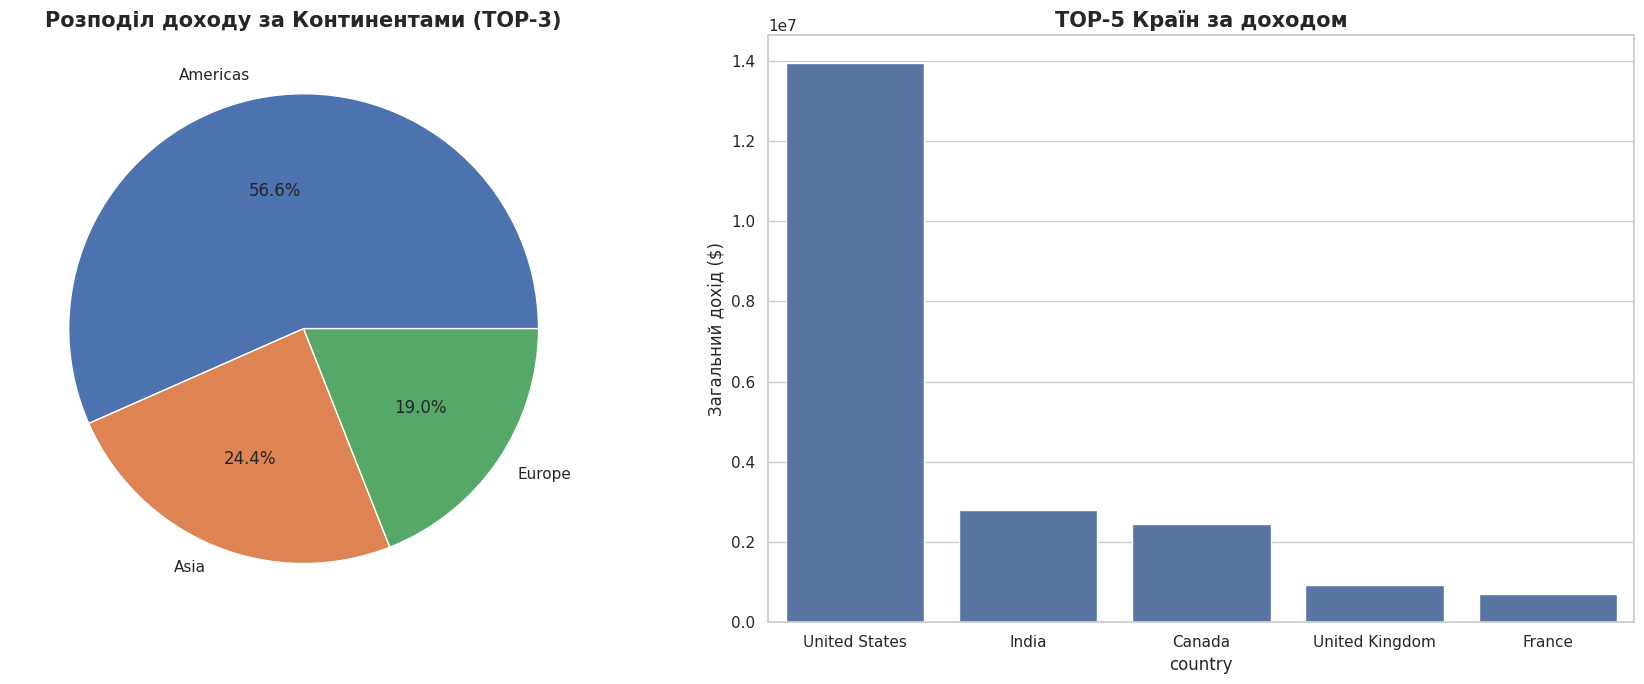

ТОП-3 Континенти за доходом: continent
Americas    17665280.0
Asia         7601298.3
Europe       5934624.2
Name: total_revenue, dtype: float64

ТОП-5 Країн за доходом:
            country  total_revenue  order_count
31    United States     13943553.9        14673
44            India      2809762.0         3029
15           Canada      2437921.0         2560
109  United Kingdom       938317.9         1029
84           France       710692.8          678


In [ ]:
geo_stats = df.groupby(['continent', 'country']).agg(
    total_revenue=('price', 'sum'),
    order_count=('price', 'count')
).reset_index()

top_continents = geo_stats.groupby('continent')['total_revenue'].sum().sort_values(ascending=False).head(3)

top_countries = geo_stats.sort_values(by='total_revenue', ascending=False).head(5)

fig, ax = plt.subplots(1, 2, figsize=(18, 7))

ax[0].pie(top_continents, labels=top_continents.index, autopct='%1.1f%%')
ax[0].set_title('Розподіл доходу за Континентами (TOP-3)', fontsize=15, fontweight='bold')

sns.barplot(data=top_countries, x='country', y='total_revenue', ax=ax[1])
ax[1].set_title('TOP-5 Країн за доходом', fontsize=15, fontweight='bold')
ax[1].set_ylabel('Загальний дохід ($)')

plt.tight_layout()
plt.show()

print(f"ТОП-3 Континенти за доходом: {top_continents}")

print(f"\nТОП-5 Країн за доходом:\n{top_countries[['country', 'total_revenue', 'order_count']]}")

ТОП-3 Континенти за доходом:
1.      Americas - 17665280.0
2.      Asia - 7601298.3
3.      Europe  -  5934624.2


ТОП-5 Країн за доходом:

            country          total_revenue    order_count
1.          United States    13943553.9       14673
2.          India            2809762.0        3029
3.          Canada           2437921.0        2560
4.          United Kingdom   938317.9         1029
5.          France           710692.8         678

Ринок США є абсолютним лідером бізнесу, забезпечуючи понад 50% як трафіку, так і загальної виручки

In [ ]:
top_categories_global = df.groupby('product_category')['price'].sum().sort_values(ascending=False).head(10)

top_country_name = top_countries.iloc[0]['country']

top_categories_country = df[df['country'] == top_country_name].groupby('product_category')['price'].sum().sort_values(ascending=False).head(10)

print(f" ТОП-10 категорій у світі:\n{top_categories_global.index.tolist()}")
print(f"\n ТОП-10 категорій у {top_country_name}:\n{top_categories_country.index.tolist()}")


 ТОП-10 категорій у світі:
['Sofas & armchairs', 'Chairs', 'Beds', 'Bookcases & shelving units', 'Cabinets & cupboards', 'Outdoor furniture', 'Tables & desks', 'Chests of drawers & drawer units', 'Bar furniture', "Children's furniture"]

 ТОП-10 категорій у United States:
['Sofas & armchairs', 'Chairs', 'Beds', 'Bookcases & shelving units', 'Cabinets & cupboards', 'Outdoor furniture', 'Tables & desks', 'Chests of drawers & drawer units', 'Bar furniture', "Children's furniture"]


Попит на топ категорії є абсолютно однаковим у  світі та окремо в США.

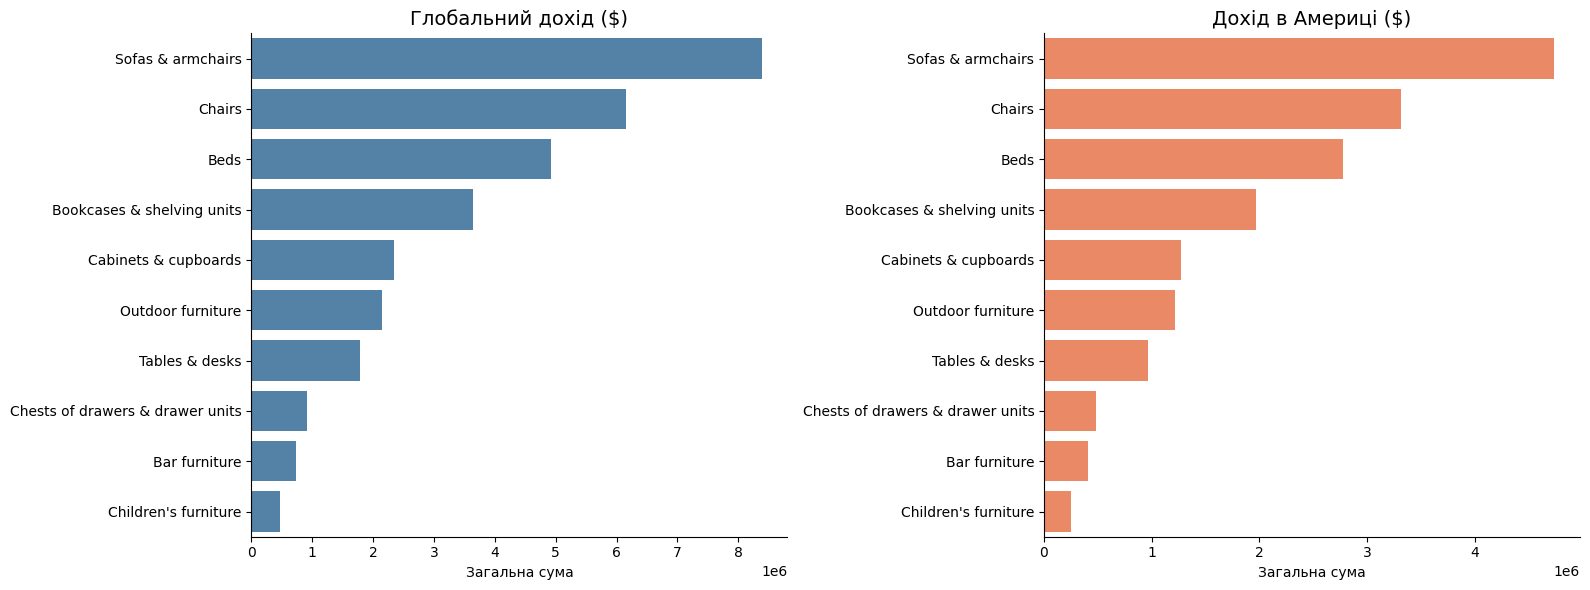

Порівняння ТОП-10 категорій за доходом та частка ринку Америки:


,product_category,price_Global,price_Americas,Americas_Share_%
0,Sofas & armchairs,8388254.5,4737307.0,56.48
1,Chairs,6147748.8,3309203.0,53.83
2,Beds,4919725.0,2773094.0,56.37
3,Bookcases & shelving units,3640818.1,1968919.3,54.08
4,Cabinets & cupboards,2336499.5,1275562.5,54.59
5,Outdoor furniture,2142222.2,1213115.2,56.63
6,Tables & desks,1790307.5,968129.0,54.08
7,Chests of drawers & drawer units,906562.5,484290.0,53.42
8,Bar furniture,735503.0,406198.0,55.23
9,Children's furniture,467697.0,253435.0,54.19


In [ ]:
top_rev_global = df.groupby('product_category')['price'].sum().nlargest(10).reset_index()
top_rev_usa = df[df['continent'] == 'Americas'].groupby('product_category')['price'].sum().nlargest(10).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x='price', y='product_category', data=top_rev_global, ax=axes[0], color='steelblue')
axes[0].set_title('Глобальний дохід ($)', fontsize=14)
axes[0].set_xlabel('Загальна сума')
axes[0].set_ylabel('')

sns.barplot(x='price', y='product_category', data=top_rev_usa, ax=axes[1], color='coral')
axes[1].set_title('Дохід в Америці ($)', fontsize=14)
axes[1].set_xlabel('Загальна сума')
axes[1].set_ylabel('')

sns.despine()
plt.tight_layout()
plt.show()

comparison_table = pd.merge(
    top_rev_global,
    top_rev_usa,
    on='product_category',
    how='left',
    suffixes=('_Global', '_Americas')
).fillna(0)

comparison_table['Americas_Share_%'] = (comparison_table['price_Americas'] / comparison_table['price_Global'] * 100).round(2)

print("Порівняння ТОП-10 категорій за доходом та частка ринку Америки:")
display(comparison_table.nlargest(10, 'price_Global').reset_index(drop=True))

Ключові інсайти:
1. Ринок Америки стабільно генерує більше половини (54–56%) всього світового доходу в кожній топовій категорії.

2. Топ-категорія Sofas & armchairs абсолютний лідер з доходом понад 8.3 млн глобально.

3. Перші три категорії (дивани, стільці, ліжка) приносять основну масу грошей.
Всі інші категорії суттєво відстають за обсягами.
4. Товари з Children's furniture має найнижчий дохід (менше 0.5 млн)

Стислий висновок:
Бізнес тримається на великих меблях (дивани, стільці, ліжка), де американський ринок є критично важливим (понад 50% виручки) тому буде доцільним розвивати саме топ категорііі в США.

##Продажі за джерелами трафіку та типом девайсу

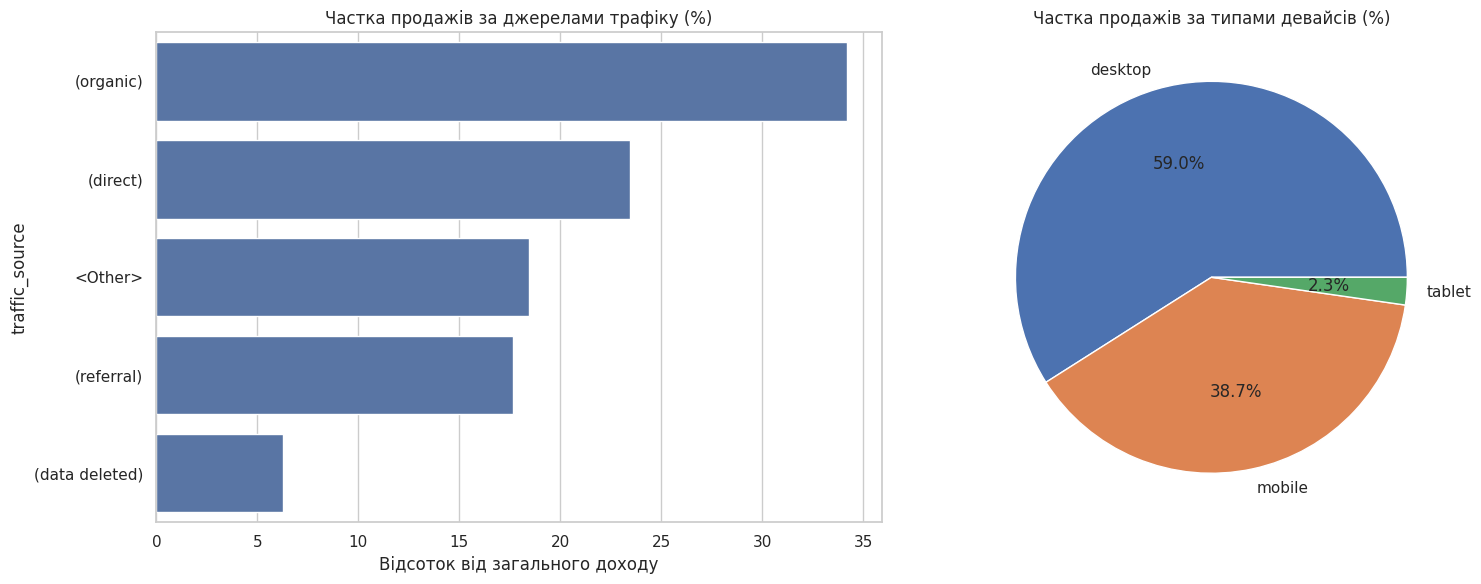

Частка продажів за джерелами трафіку (%): traffic_source
(organic)         34.20
(direct)          23.44
<Other>           18.45
(referral)        17.65
(data deleted)     6.26
Name: price, dtype: float64

Частка продажів за типами девайсів (%): device
desktop    59.00
mobile     38.73
tablet      2.26
Name: price, dtype: float64


In [ ]:
total_revenue = df['price'].sum()

traffic_share = (df.groupby('traffic_source')['price'].sum() / total_revenue * 100).sort_values(ascending=False).head(10)

device_share = (df.groupby('device')['price'].sum() / total_revenue * 100).sort_values(ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

traffic_data = (df.groupby('traffic_source')['price'].sum() / df['price'].sum() * 100).sort_values(ascending=False)
sns.barplot(x=traffic_data.values, y=traffic_data.index, ax=ax[0])
ax[0].set_title('Частка продажів за джерелами трафіку (%)')
ax[0].set_xlabel('Відсоток від загального доходу')


device_data = (df.groupby('device')['price'].sum() / df['price'].sum() * 100).sort_values(ascending=False)
ax[1].pie(device_data, labels=device_data.index, autopct='%1.1f%%')
ax[1].set_title('Частка продажів за типами девайсів (%)')

plt.tight_layout()
plt.show()

print(f"Частка продажів за джерелами трафіку (%): {traffic_share.round(2)}")

print(f"\nЧастка продажів за типами девайсів (%): {device_share.round(2)}")


Частка продажів за джерелами трафіку (%)
1.      organic        34.20
2.      direct         23.44
3.      Other          18.45
4.      referral       17.65
5.      data deleted   6.26


Частка продажів за типами девайсів (%)
1.     desktop    59.00
2.     mobile     38.73
3.     tablet     2.26


Найбільшу частку продажів забезпечує канал organic 34.20%, за ним ідуть direct 23.44%, other 18.45% та referral 17.65%.

Частка продажів Desktop займає 59% ринку, Mobile — 38.7%, а Tablet — лише 2.26%.

##Аналіз зареєстрованих користувачів


Підтвердили : 71.70%
Відписалися : 16.94%

Порівняння


,Average Check,Orders
is_unsubscribed,,
0,921.506812,2334
1,965.820134,447


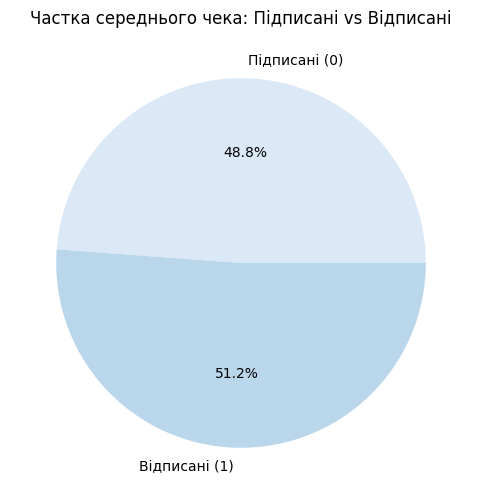

In [ ]:
users = df[df['user_id'].notnull()].drop_duplicates('user_id')
confirmed_pct = (users['email_confirmed'].astype(float).mean() * 100)
unsubscribed_pct = (users['is_unsubscribed'].astype(float).mean() * 100)

print(f"Підтвердили : {confirmed_pct:.2f}%")
print(f"Відписалися : {unsubscribed_pct:.2f}%")

behavior = df[df['user_id'].notnull()].groupby('is_unsubscribed')['price'].agg(['mean', 'count']).rename(columns={'mean': 'Average Check', 'count': 'Orders'})

print("\nПорівняння")
display(behavior)

plt.figure(figsize=(6, 6))
plt.pie(behavior['Average Check'],
        labels=['Підписані (0)', 'Відписані (1)'],
        autopct='%1.1f%%',
        colors=sns.color_palette('Blues'))

plt.title('Частка середнього чека: Підписані vs Відписані')
plt.show()


Бачимо що хоча і підписники генерують основний обсяг замовлень, користувачі, які відписалися від розсилки, мають вищий середній чек. Це може свідчити про те, що досвідчені купують частіше, але дешевший товар або покупці дорожчих товарів більш чутливі до реклами, не мають вільного часу та частіше відписуються.

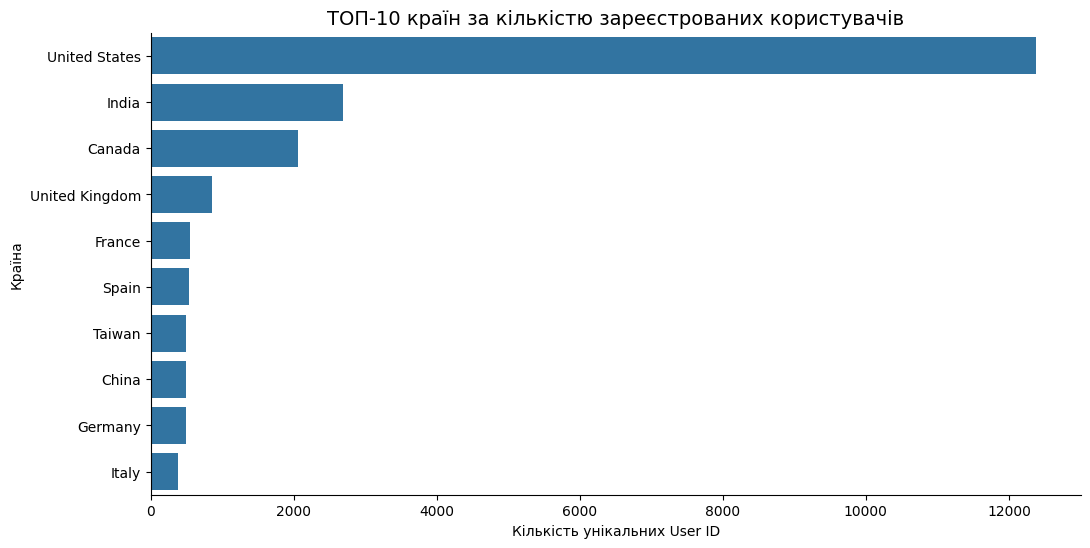

Країни з найбільшою кількістю зареєстрованих користувачів:


,country,user_id
0,United States,12384
1,India,2687
2,Canada,2067
3,United Kingdom,859
4,France,553
5,Spain,536
6,Taiwan,500
7,China,490
8,Germany,490
9,Italy,386


In [ ]:
registered_users = df[df['user_id'].notnull()]

top_registered_countries = registered_users.groupby('country')['user_id'].nunique().nlargest(10).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='user_id', y='country', data=top_registered_countries)
plt.title('ТОП-10 країн за кількістю зареєстрованих користувачів', fontsize=14)
plt.xlabel('Кількість унікальних User ID')
plt.ylabel('Країна')
sns.despine()
plt.show()

print("Країни з найбільшою кількістю зареєстрованих користувачів:")
display(top_registered_countries)

Кількість зареєстрованих користувачів у США (12 384) у кілька разів перевищує сумарну кількість реєстрацій у наступних дев'яти країнах разом узятих. Це ще раз підтверджує, що ринок США є абсолютним лідером бізнесу.

Text(0, 0.5, 'Сума продажів')

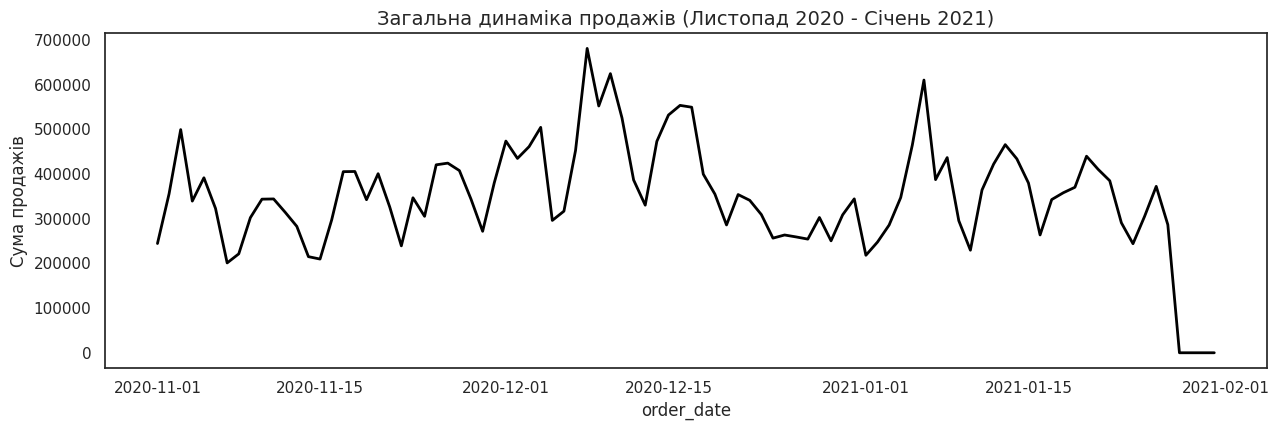

In [ ]:
daily_sales = df.groupby('order_date')['price'].sum().reset_index()

plt.figure(figsize=(15, 20))
plt.subplot(4, 1, 1)
sns.lineplot(data=daily_sales, x='order_date', y='price', color='black', linewidth=2)
plt.title('Загальна динаміка продажів (Листопад 2020 - Січень 2021)', fontsize=14)
plt.ylabel('Сума продажів')


Протягом періоду спостерігається стабільна активність із вираженими коливаннями.
Головний пік продажів зафіксовано на початку грудня 2020 року (сума сягнула майже 700 000), що свідчить про успішний старт передноворічних розпродажів.Також помітне зростання продажів відбулося на початку січня 2021 року (почали витарчати подарованні гроші).
Різке падіння показників до нуля наприкінці січня виглядає як помилка в даних або припинення їх збору, а не реальний спад продажів.

Text(0, 0.5, 'Сума продажів')

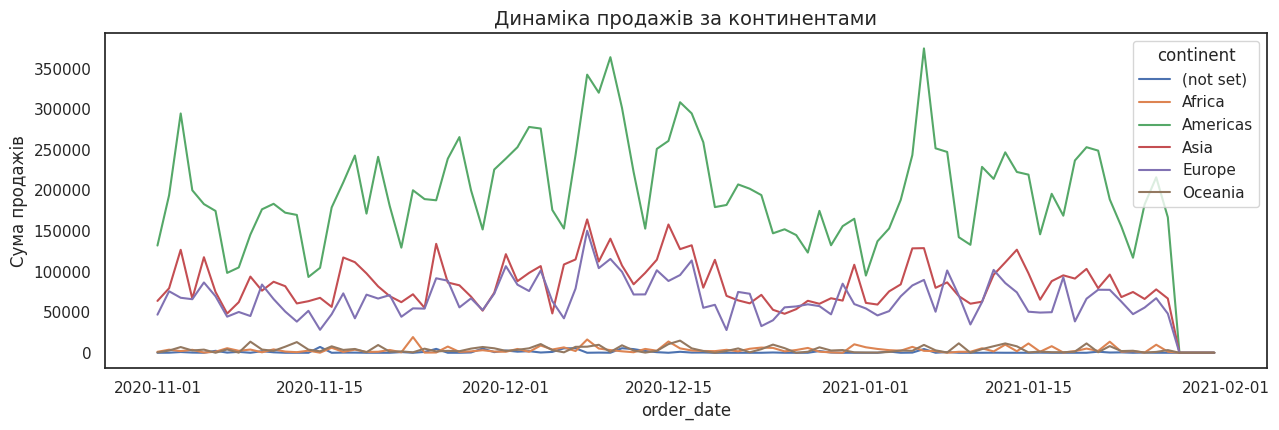

In [ ]:
plt.figure(figsize=(15, 20))
plt.subplot(4, 1, 2)
geo_trend = df.groupby(['order_date', 'continent'])['price'].sum().reset_index()
sns.lineplot(data=geo_trend, x='order_date', y='price', hue='continent')
plt.title('Динаміка продажів за континентами', fontsize=14)
plt.ylabel('Сума продажів')

Зелена лінія на графіку вкотре показує, що ринок Америки є абсолютним лідером і формує основний тренд загальних продажів. ТАкож Європа та Азія демонструють схожу динаміку, але в менших обсягах.А ось Африка та Океанія мають мінімальний вплив на загальну виручку.

Text(0.5, 1.0, 'Динаміка продажів за каналами трафіку')

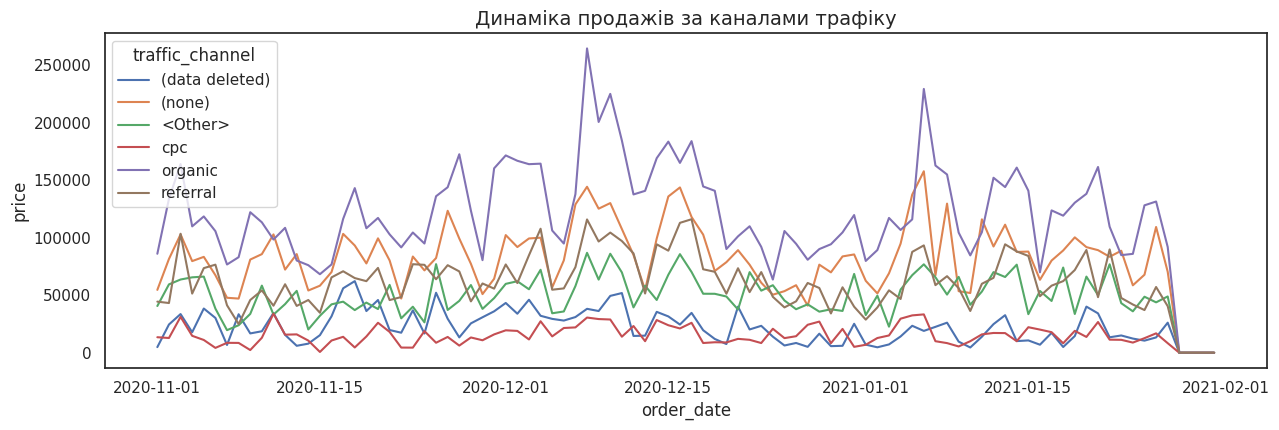

In [ ]:
plt.figure(figsize=(15, 20))
plt.subplot(4, 1, 3)
traffic_trend = df.groupby(['order_date', 'traffic_channel'])['price'].sum().reset_index()
sns.lineplot(data=traffic_trend, x='order_date', y='price', hue='traffic_channel')
plt.title('Динаміка продажів за каналами трафіку', fontsize=14)

Основним джерелом доходу є Organic (пошуковий трафік), що свідчить про ефективність SEO. Друге місце посідають прямі заходи (none), що вказує на впізнаваність бренду. Платна реклама (cpc) має найнижчий вплив на загальні продажі.


Text(0.5, 1.0, 'Динаміка продажів за типами девайсів')

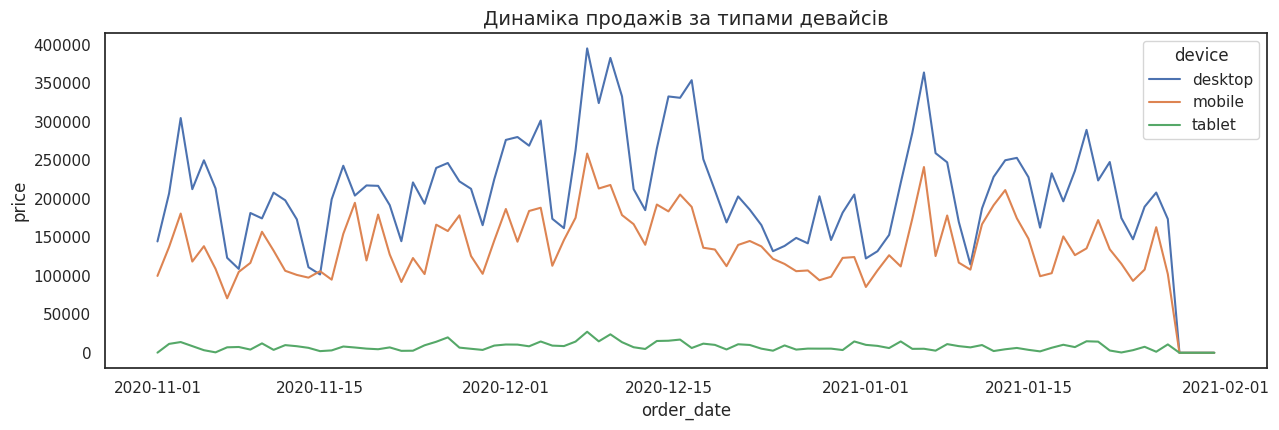

In [ ]:
plt.figure(figsize=(15, 20))
plt.subplot(4, 1, 4)
device_trend = df.groupby(['order_date', 'device'])['price'].sum().reset_index()
sns.lineplot(data=device_trend, x='order_date', y='price', hue='device')
plt.title('Динаміка продажів за типами девайсів', fontsize=14)

Найбільшу частку доходу стабільно приносять користувачі desktop (комп’ютери). Це основне джерело продажів протягом усього періоду. Продажі з mobile посідають друге місце, повторюючи загальний тренд десктопної версії, але з меншим обсягом. Продажі з tablet (планшети) залишаються стабільно низькими, майже не впливаючи на загальний результат.

##Матричний аналіз

In [ ]:
clean_df = df[
    (df['traffic_channel'].notnull()) & (df['traffic_channel'] != '(none)') &
    (df['device'].notnull()) & (df['device'] != '(not set)')
]

pivot_sessions = clean_df.pivot_table(
    index='traffic_channel',
    columns='device',
    values='session_id',
    aggfunc='nunique'
).fillna(0)

print("Унікальні сесії (Канал vs Девайс)")
display(pivot_sessions)

Унікальні сесії (Канал vs Девайс)


device,desktop,mobile,tablet
traffic_channel,,,
(data deleted),12756,8624,479
<Other>,29554,19860,1179
cpc,8972,5921,357
organic,69431,46934,2659
referral,35891,24183,1363


Organic є абсолютним лідером за кількістю сесій на всіх типах пристроїв (69,431 на desktop та 46,934 на mobile). Це свідчить про дуже сильну SEO-оптимізацію (знаходять самостійно).
На всіх каналах кількість сесій з desktop значно вища, ніж з mobile. Це підтверджує попередній інсайт, що  аудиторія воліє використовувати комп'ютери для взаємодії з магазином. Можливо, процес вибору товару або оформлення замовлення складний і потребує великого екрана.
Канал referral (переходи з інших сайтів, зовнішні посилання та партнерства) займає впевнене друге місце.
Сесії з планшетів становлять найменшу частку в усіх каналах. Це підтверджує, що фокусувати ресурси на оптимізації саме під планшети зараз не є пріоритетом.

In [ ]:
top_5_countries = df.groupby('country')['price'].sum().nlargest(5).index
top_10_categories = df.groupby('product_category')['price'].sum().nlargest(10).index

pivot_sales = df[
    df['country'].isin(top_5_countries) &
    df['product_category'].isin(top_10_categories)
].pivot_table(
    index='product_category',
    columns='country',
    values='price',
    aggfunc='sum'
).fillna(0)

print("\nПродажі ТОП-10 категорій у ТОП-5 країнах")
display(pivot_sales)


Продажі ТОП-10 категорій у ТОП-5 країнах


country,Canada,France,India,United Kingdom,United States
product_category,,,,,
Bar furniture,51724.0,11199.0,57657.0,22103.0,330805.0
Beds,354772.0,116414.0,358319.5,133816.0,2213058.0
Bookcases & shelving units,278981.9,73830.0,364507.4,113987.6,1567606.9
Cabinets & cupboards,181802.0,59101.5,191888.0,71684.5,994545.5
Chairs,417740.8,134029.4,544309.2,188519.4,2619773.8
Chests of drawers & drawer units,71952.0,21544.5,73111.0,36784.0,382388.0
Children's furniture,30264.0,14258.0,39177.0,13348.0,207575.0
Outdoor furniture,185322.8,40486.4,162289.4,57002.4,929245.2
Sofas & armchairs,692427.5,187735.0,788430.0,234812.0,3707144.5


Найбільше грошей приносять дивани (Sofas), стільці (Chairs) та ліжка (Beds). Це фундамент продажів у всіх країнах.Також бачимо, що ринок США не просто більшийа, він генерує значно більше виручки, ніж решта 4 країни разом узяті. Це пріоритет №1 для ресурсів. ТАкож цікаво було побачити, що Індія обійшла Канаду, Францію та Британію майже за всіма позиціями. Це найбільш динамічний ринок після США з високим попитом на стелажі (Bookcases).Барні та дитячі меблі продаються найгірше. Це свідчить про те, що клієнт приходить за базовим комфортом, а не за нішевими рішеннями.

Стислий висновок:
Бізнес тримається на масовому сегменті м'яких меблів у США. Найбільший потенціал для експансії Індія, а найменш ефективний ринок зараз Франція.

In [ ]:
pivot_aov = df.pivot_table(
    index='operating_system',
    columns='continent',
    values='price',
    aggfunc='mean'
).round(2).fillna(0)

print("\nСередній чек за OS та Континентом")
display(pivot_aov)



Середній чек за OS та Континентом


continent,(not set),Africa,Americas,Asia,Europe,Oceania
operating_system,,,,,,
<Other>,1167.33,618.33,931.28,940.15,941.01,712.22
Android,0.00,1159.44,980.43,1004.67,896.08,1462.32
Macintosh,876.25,1888.28,928.22,1054.62,931.97,1453.23
Web,1110.74,999.83,944.51,947.73,938.81,862.12
Windows,1166.90,624.64,979.15,906.34,1062.07,1216.82
iOS,705.11,634.10,962.74,949.82,932.14,931.95


Користувачі Macintosh в Африці мають найвищий середній чек 1888.28. Це майже вдвічі більше, ніж середній показник по інших категоріях. Схожа тенденція в Океанії (1453.23), що вказує на концентрацію найбільш платоспроможних клієнтів саме на цих пристроях у віддалених регіонах.
Windows та Web показують найбільш рівномірні результати у всіх ключових регіонах (Америка, Азія, Європа) чеки стабільно тримаються в межах 900–1000. Найнижчі показники зафіксовані в Африці для Windows (624.64), iOS (634.10) та категорії "Other" (618.33). Там ринок чітко розділений: або дуже дорогі покупки , або бюджетний сегмент.
Для Android у колонці "(not set)" значення 0.00. Скоріш за все це свідчить про проблему збору даних або помилку в налаштуваннях аналітики для цієї групи.

##Статистичний аналіз


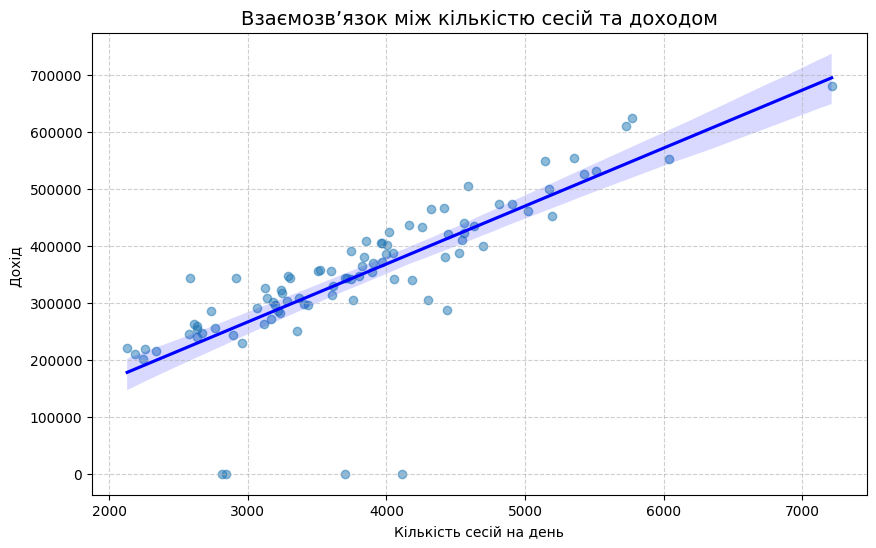

Коефіцієнт кореляції Пірсона (r): 0.7911
Статистична значущість (p-value): 6.4835e-21


In [ ]:
daily_metrics = df.groupby('order_date').agg({
    'session_id': 'count',
    'price': 'sum'
}).rename(columns={'session_id': 'sessions', 'price': 'revenue'})

plt.figure(figsize=(10, 6))
sns.regplot(x='sessions', y='revenue', data=daily_metrics, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'})
plt.title('Взаємозв’язок між кількістю сесій та доходом', fontsize=14)
plt.xlabel('Кількість сесій на день')
plt.ylabel('Дохід ')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

correlation, p_value = stats.pearsonr(daily_metrics['sessions'], daily_metrics['revenue'])

print(f"Коефіцієнт кореляції Пірсона (r): {correlation:.4f}")
print(f"Статистична значущість (p-value): {p_value:.4e}")

Коефіцієнт кореляції Пірсона 0.7911. Це свідчить про сильний позитивний зв'язок між кількістю сесій та обсягом продажів.
Статистична значущість (p-value < 0.05), тому зв'язок між метриками є статистично значущим.

Висновок: Графік розсіювання чітко показує лінійну залежність. Це підтверджує, що кількість трафіку є надійним прогнозистом доходу. Пряме залучення більшої кількості сесій призведе до прогнозованого зростання виручки.



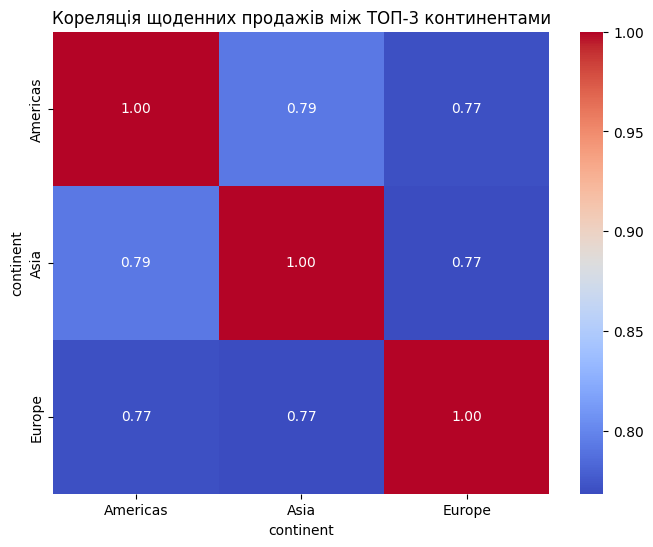

Статистична значущість взаємозв’язків (P-values):
Americas vs Europe: r = 0.771, p-value = 2.6714e-19
Americas vs Asia: r = 0.792, p-value = 5.4092e-21
Europe vs Asia: r = 0.768, p-value = 3.8649e-19


In [ ]:
pivot_revenue = df.pivot_table(
    index='order_date',
    columns='continent',
    values='price',
    aggfunc='sum'
).fillna(0)

top_3_continents = df.groupby('continent')['price'].sum().nlargest(3).index
subset_revenue = pivot_revenue[top_3_continents]

corr_matrix = subset_revenue.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Кореляція щоденних продажів між ТОП-3 континентами')
plt.show()

print("Статистична значущість взаємозв’язків (P-values):")
pairs = [('Americas', 'Europe'), ('Americas', 'Asia'), ('Europe', 'Asia')]
for c1, c2 in pairs:
    if c1 in subset_revenue.columns and c2 in subset_revenue.columns:
        r, p = pearsonr(subset_revenue[c1], subset_revenue[c2])
        print(f"{c1} vs {c2}: r = {r:.3f}, p-value = {p:.4e}")

Висновок: Усі три регіони мають сильну позитивну кореляцію між собою. Також В усіх випадках p-value є надзвичайно низьким, що гарантує статистично підтверджену достовірність знайдених зв’язків.


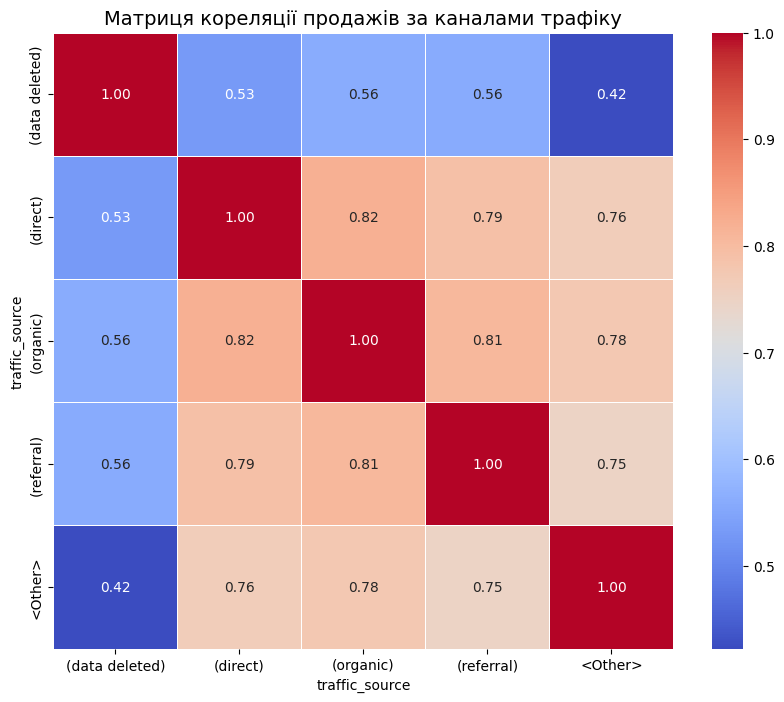

 Результати аналізу взаємозв'язку між каналами трафіку:


,Пара каналів,Коефіцієнт кореляції (r),p-value
0,(data deleted) vs (direct),0.5329,4.5471e-08
1,(data deleted) vs (organic),0.5601,6.4269e-09
2,(data deleted) vs (referral),0.5600,6.4717e-09
3,(data deleted) vs <Other>,0.4225,2.7317e-05
4,(direct) vs (organic),0.8209,1.2763e-23
5,(direct) vs (referral),0.7922,5.2282e-21
6,(direct) vs <Other>,0.7641,8.0359e-19
7,(organic) vs (referral),0.8061,3.2548e-22
8,(organic) vs <Other>,0.7758,1.0760e-19
9,(referral) vs <Other>,0.7478,1.0913e-17


In [ ]:
pivot_traffic = df.pivot_table(
    index='order_date',
    columns='traffic_source',
    values='price',
    aggfunc='sum'
).fillna(0)

plt.figure(figsize=(10, 8))
sns.heatmap(traffic_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Матриця кореляції продажів за каналами трафіку', fontsize=14)
plt.show()

pivot_traffic = df.pivot_table(
    index='order_date',
    columns='traffic_source',
    values='price',
    aggfunc='sum'
).fillna(0)

results = []
columns = pivot_traffic.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]

        r_val, p_val = pearsonr(pivot_traffic[col1], pivot_traffic[col2])

        results.append({
            'Пара каналів': f"{col1} vs {col2}",
            'Коефіцієнт кореляції (r)': round(r_val, 4),
            'p-value': f"{p_val:.4e}"
        })
correlation_table = pd.DataFrame(results)

print(" Результати аналізу взаємозв'язку між каналами трафіку:")
display(correlation_table)


Висновок: Найвищий ступінь залежності зафіксовано між Direct та Organic Search. Це може свідчити про те, що пошукове просування безпосередньо впливає на впізнаваність бренду і як результат користувачі, що знаходять сайт в пошуку, згодом частіше повертаються на нього напряму. Також Для всіх проаналізованих пар каналів показник p-value значно менший за 0.05, що є беззаперечним доказом того, що виявлені кореляції не є випадковими, а мають системний характер.

In [ ]:
top_5_categories = df.groupby('product_category')['price'].sum().nlargest(5).index

pivot_categories = df[df['product_category'].isin(top_5_categories)].pivot_table(
    index='order_date',
    columns='product_category',
    values='price',
    aggfunc='sum'
).fillna(0)

results_list = []
cols = pivot_categories.columns

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        r_val, p_val = pearsonr(pivot_categories[cols[i]], pivot_categories[cols[j]])
        results_list.append({
            'Пара категорій': f"{cols[i]} <-> {cols[j]}",
            'Коефіцієнт r': round(r_val, 4),
            'p-value': f"{p_val:.4e}"
        })

final_table = pd.DataFrame(results_list)

display(final_table)

,Пара категорій,Коефіцієнт r,p-value
0,Beds <-> Bookcases & shelving units,0.5929,1.1550e-09
1,Beds <-> Cabinets & cupboards,0.5146,2.9109e-07
2,Beds <-> Chairs,0.5545,2.0792e-08
3,Beds <-> Sofas & armchairs,0.5354,7.6873e-08
4,Bookcases & shelving units <-> Cabinets & cupb...,0.5394,5.8672e-08
5,Bookcases & shelving units <-> Chairs,0.6371,2.5046e-11
6,Bookcases & shelving units <-> Sofas & armchairs,0.6662,1.4070e-12
7,Cabinets & cupboards <-> Chairs,0.5729,5.4659e-09
8,Cabinets & cupboards <-> Sofas & armchairs,0.6576,3.4151e-12
9,Chairs <-> Sofas & armchairs,0.5782,3.6388e-09


Висновок: Аналіз продажів у розрізі основних меблевих категорій вказує на приблизно однакову корреляцію, а p-value значно менше за 0.05, що підтверджує стійку залежність між попитом на різні типи меблів.

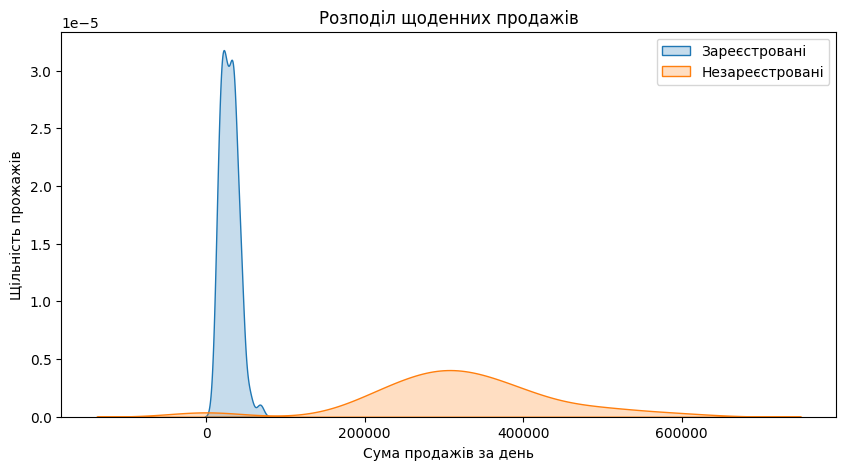

P-value (Reg): 0.0073
P-value(Non-reg): 0.0012

Порівняння щоденних продажів:
P-value: 0.0000
Висновок: Є статистично значуща різниця.


In [ ]:
reg_sales = df[df['user_id'].notnull()].groupby('order_date')['price'].sum()
non_reg_sales = df[df['user_id'].isnull()].groupby('order_date')['price'].sum()

plt.figure(figsize=(10, 5))
sns.kdeplot(reg_sales, label='Зареєстровані', fill=True)
sns.kdeplot(non_reg_sales, label='Незареєстровані', fill=True)
plt.title('Розподіл щоденних продажів')
plt.xlabel('Сума продажів за день')
plt.ylabel('Щільність прожажів')
plt.legend()
plt.show()

_, p_norm_reg = stats.shapiro(reg_sales)
_, p_norm_non_reg = stats.shapiro(non_reg_sales)
print(f"P-value (Reg): {p_norm_reg:.4f}")
print(f"P-value(Non-reg): {p_norm_non_reg:.4f}")

u_stat, p_val = stats.mannwhitneyu(reg_sales, non_reg_sales)

print(f"\nПорівняння щоденних продажів:")
print(f"P-value: {p_val:.4f}")

alpha = 0.05
if p_val < alpha:
    print("Висновок: Є статистично значуща різниця.")
else:
    print("Висновок: Статистично значущої різниці не виявлено.")

Порівняння продажів: Зареєстровані vs Незареєстровані.

Нормальність розподілу перевірено тестом Шапіро–Уїлком який показав що розподіл ненормальний тому використаємо тест Манна-Уїтні.

Висновок: Статистичний аналіз показав статистично значущу різницю (P-value < 0.05), що незареєстровані користувачі приносять компанії значно більше доходу на щоденній основі, ніж зареєстровані. Висока щільність даних у зареєстрованих користувачів біля низьких значень свідчить про їхню стабільну, але низьку активність, тоді як незареєстровані формують основний обсяг продажів.

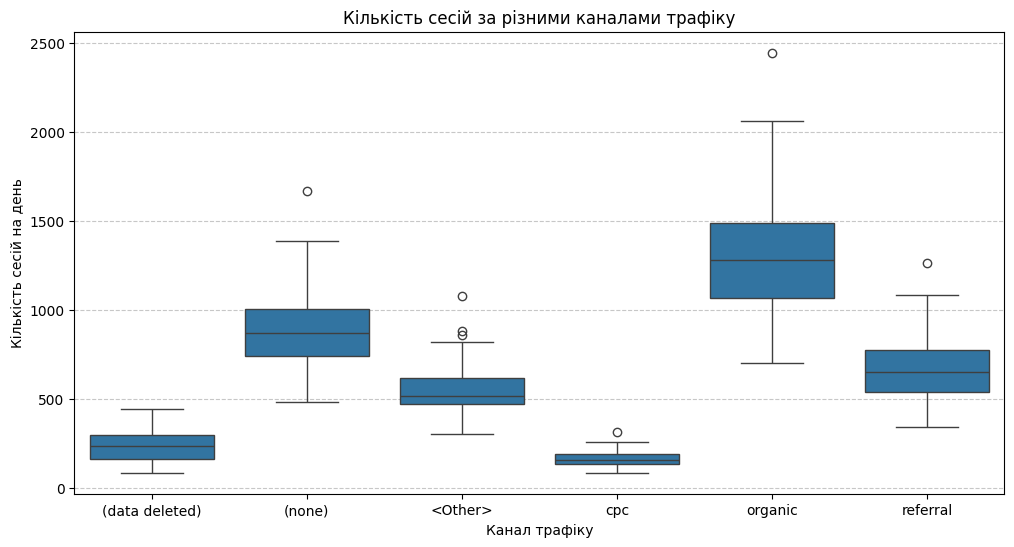

Аналіз каналів трафіку:
P-value (Kruskal-Wallis): 0.0000
Висновок: Між каналами трафіку є статистично значуща різниця.


In [ ]:
sessions_by_channel = df.groupby(['order_date', 'traffic_channel']).size().reset_index(name='session_count')

channels = sessions_by_channel['traffic_channel'].unique()
data_groups = [sessions_by_channel[sessions_by_channel['traffic_channel'] == ch]['session_count'] for ch in channels]

plt.figure(figsize=(12, 6))
sns.boxplot(x='traffic_channel', y='session_count', data=sessions_by_channel)
plt.title('Кількість сесій за різними каналами трафіку')
plt.xlabel('Канал трафіку')
plt.ylabel('Кількість сесій на день')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

h_stat, p_val_kw = stats.kruskal(*data_groups)

print(f"Аналіз каналів трафіку:")
print(f"P-value (Kruskal-Wallis): {p_val_kw:.4f}")

if p_val_kw < 0.05:
    print("Висновок: Між каналами трафіку є статистично значуща різниця.")
else:
    print("Висновок: Статистично значущої різниці між каналами не виявлено.")

Порівняння каналів трафіку.

Висновок: За результатами тесту Краскела-Уолліса (p-value < 0.05) ми відхиляємо нульову гіпотезу про рівність медіан. Це підтверджує, що вибір каналу трафіку має статистично значущий вплив на кількість сесій.В данному випадку бачимо, що канал "organic" забезпечує основний обсяг відвідувань, тоді як інші канали відіграють допоміжну роль

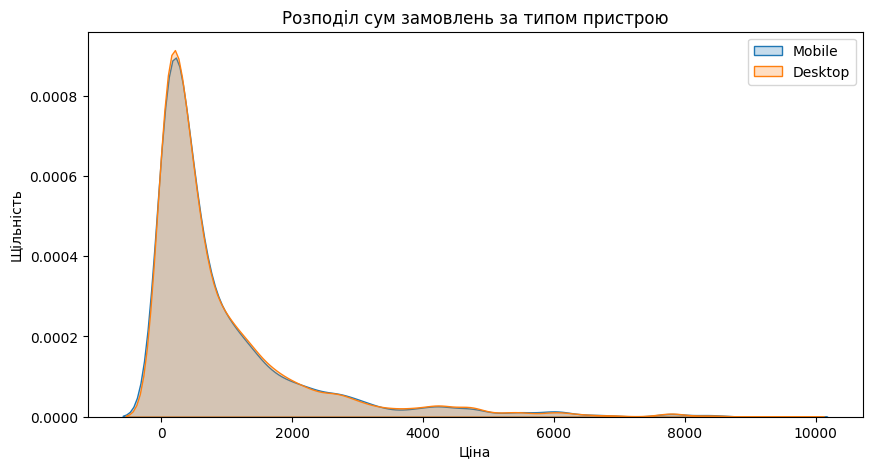

P-value (Mobile): 0.0000
P-value (Desktop): 0.0000

Результат порівняння Mobile vs Desktop:
P-value: 0.1586


In [ ]:
mobile_prices = df[df['device'] == 'mobile']['price'].dropna()
desktop_prices = df[df['device'] == 'desktop']['price'].dropna()

plt.figure(figsize=(10, 5))
sns.kdeplot(mobile_prices, label='Mobile', fill=True)
sns.kdeplot(desktop_prices, label='Desktop', fill=True)
plt.title('Розподіл сум замовлень за типом пристрою')
plt.xlabel('Ціна')
plt.ylabel('Щільність')
plt.legend()
plt.show()

_, p_mob = stats.shapiro(mobile_prices.sample(min(len(mobile_prices), 500)))
_, p_desk = stats.shapiro(desktop_prices.sample(min(len(desktop_prices), 500)))

print(f"P-value (Mobile): {p_mob:.4f}")
print(f"P-value (Desktop): {p_desk:.4f}")

u_stat, p_val = stats.mannwhitneyu(mobile_prices, desktop_prices)

print(f"\nРезультат порівняння Mobile vs Desktop:")
print(f"P-value: {p_val:.4f}")

Порівняння замовлень Mobile vs Desktop

Висновок: Аналіз сум замовлень не виявив статистично значущої різниці між пристроями (P-value < 0.05). Графіки щільності розподілу практично ідентичні, а тест Манна-Уїтні підтвердив, що поведінка покупців щодо витрат однакова як на смартфонах, так і на комп'ютерах/

### Dashboard

https://public.tableau.com/app/profile/kyrylo.rymar/viz/SalesFlow_17714228590280/SalesFlowDashboard?publish=yes

## Загальний висновок:
Ключовим інсайтом є те, що лише дві категорії "Sofas & armchairs" та "Chairs" формують майже половину всього доходу (згідно з Парето), що вказує на високу концентрацію прибутку в м'яких меблях яку і потрібно розвивати далі.
НАйцікавішим інсайтом є те, що при детальному аналізі пристроїв виявлено, що користувачі Macintosh демонструють суттєво вищий середній чек порівняно з іншими платформами. Це свідчить про більш платоспроможну аудиторію, що робить їх пріоритетним сегментом для таргетованої реклами преміальних лінійок меблів.